In [12]:
import pandas as pd
from typing import Optional

import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networks import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score,multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau,OneCycleLR
import torch
from torch.nn.utils import clip_grad_norm_
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCELoss
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
emb = pd.read_pickle(os.path.join(Path.cwd().parent,'data','stackexchange_reduced_tags_embeddings.pkl'))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(emb['tags'])
title_embeddings = np.vstack(emb['title_embedding'].values)
body_embeddings = np.vstack(emb['question_text_embedding'].values)
num_tags = emb['tags'].apply(len).values.reshape(-1)
indices = emb.index.tolist()
val_dataset = StackOverflowDataset(
    title_embeddings=title_embeddings,
    body_embeddings=body_embeddings,
    num_tags_list=num_tags,
    binary_labels=y,
    train=False,
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
model = DSF_CrossAttn_Classifier().to(device)

In [4]:
model.load_state_dict(torch.load(os.path.join(Path.cwd().parent,'data','crossattn_model.pth')))

<All keys matched successfully>

In [ ]:
sns.set_style("whitegrid")

In [22]:
def visualize_head_alignment(model, title_vec, body_vec, sample_index, device=None):
    """
    Visualizes the Raw Alignment Score (Pre-Softmax) for each attention head.
    This shows how strongly each head 'agrees' that the Title matches the Body.
    """
    device = device or next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        # 1. Prepare Inputs
        t = torch.tensor(title_vec, dtype=torch.float32, device=device).unsqueeze(0) # (1, 4096)
        b = torch.tensor(body_vec, dtype=torch.float32, device=device).unsqueeze(0)  # (1, 4096)

        # 2. Initial Projections (Your model's Linear layers)
        t_feat = model.title_proj(t).unsqueeze(1)  # (1, 1, 1024)
        b_feat = model.body_proj(b).unsqueeze(1)   # (1, 1, 1024)
        
        # 3. MHA Internal Projections (The Missing Step)
        # We need to access the weights inside the MultiheadAttention module
        # in_proj_weight shape is (3 * embed_dim, embed_dim)
        qkv_weight = model.cross_attn.in_proj_weight
        qkv_bias = model.cross_attn.in_proj_bias
        
        # Project inputs using MHA weights
        # Note: In Cross Attention, Query comes from Title, Key/Value comes from Body
        # We perform the linear transformation manually: x @ W.t() + b
        
        # Split weights for Query, Key, Value
        embed_dim = 1024
        w_q, w_k, w_v = qkv_weight.chunk(3, dim=0)
        b_q, b_k, b_v = qkv_bias.chunk(3, dim=0)
        
        # Project Query (Title) and Key (Body)
        # Input shape to linear: (1, 1, 1024)
        q_proj = torch.nn.functional.linear(t_feat, w_q, b_q)
        k_proj = torch.nn.functional.linear(b_feat, w_k, b_k)
        
        # 4. Split into Heads
        num_heads = 8
        head_dim = embed_dim // num_heads
        scaling = float(head_dim) ** -0.5
        
        # Reshape to (Batch, SeqLen, NumHeads, HeadDim) -> (1, 1, 8, 128)
        q = q_proj.view(1, 1, num_heads, head_dim)
        k = k_proj.view(1, 1, num_heads, head_dim)
        
        # Permute for dot product: (Batch, NumHeads, SeqLen, HeadDim)
        q = q.transpose(1, 2) # (1, 8, 1, 128)
        k = k.transpose(1, 2) # (1, 8, 1, 128)
        
        # 5. Calculate Scaled Dot Product (Pre-Softmax)
        # (1, 8, 1, 128) @ (1, 8, 128, 1) -> (1, 8, 1, 1)
        raw_scores = (q @ k.transpose(-2, -1)) * scaling
        
        # Flatten to (8,)
        scores_np = raw_scores.flatten().cpu().numpy()

    # 6. Visualization
    plt.figure(figsize=(10, 5))
    
    # Color bars based on sign (Blue=Positive correlation, Red=Negative)
    colors = ['#1f77b4' if x > 0 else '#d62728' for x in scores_np]
    
    bars = plt.bar(range(1, num_heads + 1), scores_np, color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    
    plt.xlabel(f"Attention Head (1-{num_heads})")
    plt.ylabel("Alignment Score (Pre-Softmax)")
    plt.title(f"Cross-Attention Alignment per Head\n(Sample #{sample_index})")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate values
    for bar in bars:
        height = bar.get_height()
        xy_pos = (bar.get_x() + bar.get_width() / 2, height)
        text_xy = (0, 3) if height > 0 else (0, -12)
        plt.annotate(f'{height:.2f}', xy=xy_pos, xytext=text_xy,
                     textcoords="offset points", ha='center', va='bottom')
                     
    plt.show()

In [41]:
indices = np.arange(len(title_embeddings))
rng = np.random.default_rng(42)
rng.shuffle(indices)
test_size = int(0.15 * len(title_embeddings))
val_indices = indices[-test_size:]

In [42]:
emb.iloc[val_indices[0]]

title_embedding            [0.017457265, -0.011311744, 0.0009815362, -0.0...
question_text_embedding    [0.028463064, -0.015494897, 0.0140048675, -0.0...
tags                         [visual-studio-code, visual-studio-code, input]
Name: 73978880, dtype: object

In [35]:
val_dataset[0][1]

tensor([ 0.0285, -0.0155,  0.0140,  ..., -0.0031, -0.0028, -0.0117])

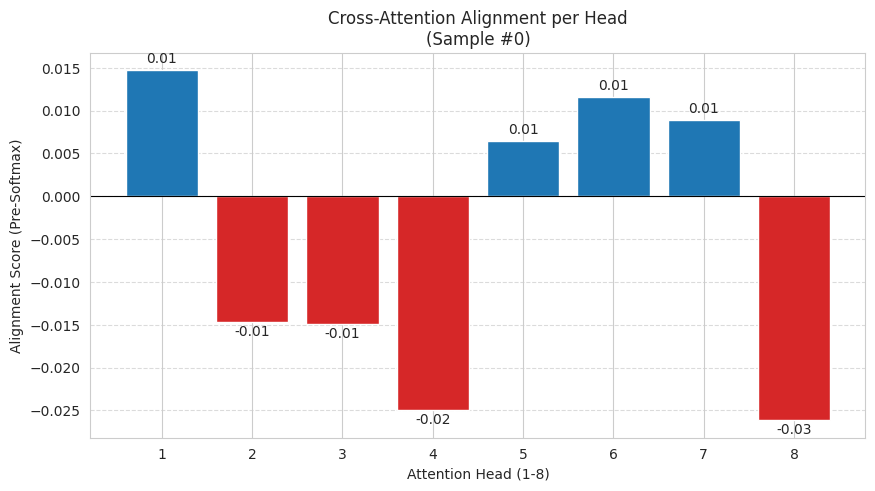

In [ ]:
sample_index = 0
title_batch, body_batch, _, _ = next(iter(val_loader))
title_vec = title_batch[sample_index % 32].numpy()
body_vec = body_batch[sample_index % 32].numpy()

visualize_head_alignment(model, title_vec, body_vec, sample_index, device=device)

In [43]:
emb.iloc[val_indices[2]]

title_embedding            [0.016354676, -0.017577816, 0.020955412, 0.001...
question_text_embedding    [0.014430367, -0.030570041, 0.03188043, -0.001...
tags                       [opengl, .net, visual-studio, visual-studio, l...
Name: 4135559, dtype: object

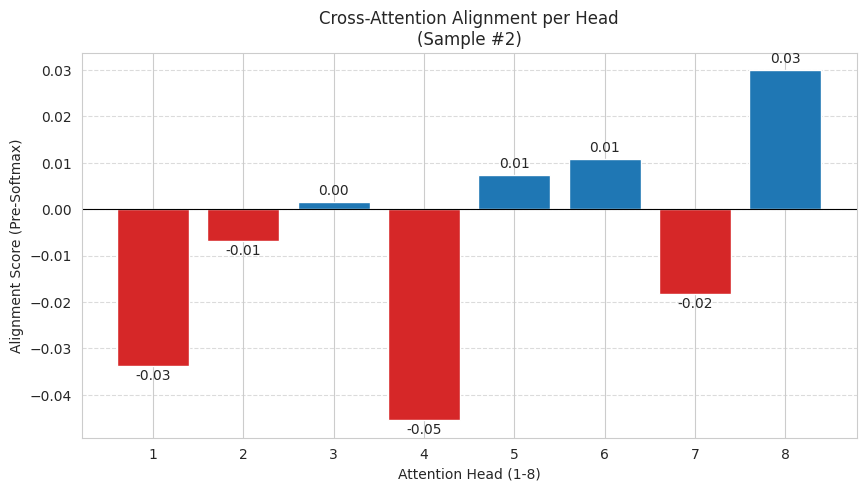

In [ ]:
sample_index = 2
title_batch, body_batch, _, _ = next(iter(val_loader))
title_vec = title_batch[sample_index % 32].numpy()
body_vec = body_batch[sample_index % 32].numpy()

visualize_head_alignment(model, title_vec, body_vec, sample_index, device=device)